In [14]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

# Get similarity data

In [3]:
#similarity = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/network_method/similarities_10m.csv')
similarities = pd.read_csv('../../data/network_method/similarities_10m.csv')

In [7]:
similarities["tanimoto_interval"] = pd.cut(
    similarities["tanimoto"],
    5,
    labels=["0.0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"],
)
similarities_tanimoto = pd.melt(
    similarities,
    id_vars="tanimoto_interval",
    value_vars=["weighted_modified_cosine", "modified_cosine"],
)

# Compare weighted and unweighted methods

In [8]:
# Look at scores for tanimoto intervals
stats = similarities_tanimoto[similarities_tanimoto.variable != 'neutral_loss']
stats.groupby(['tanimoto_interval', 'variable']).agg(['mean', 'std'])

value          
                                                mean       std
tanimoto_interval variable                                    
0.0–0.2           modified_cosine           0.051430  0.119871
                  weighted_modified_cosine  0.115677  0.126983
0.2–0.4           modified_cosine           0.047774  0.106700
                  weighted_modified_cosine  0.123560  0.132761
0.4–0.6           modified_cosine           0.056668  0.124699
                  weighted_modified_cosine  0.134465  0.150888
0.6–0.8           modified_cosine           0.156509  0.245174
                  weighted_modified_cosine  0.246487  0.227429
0.8–1.0           modified_cosine           0.348152  0.364758
                  weighted_modified_cosine  0.370672  0.270414

In [9]:
# Look at mean difference between cosine scores and tanimoto scores
similarities['weighted_tanimoto_diff'] = abs(similarities['weighted_modified_cosine'] - similarities['tanimoto'])
similarities['modified_tanimoto_diff'] = abs(similarities['modified_cosine'] - similarities['tanimoto'])
print('mean difference between weighted cosine and tanimoto scores: ', similarities['weighted_tanimoto_diff'].mean())
print('mean difference between modified cosine and tanimoto scores: ', similarities['modified_tanimoto_diff'].mean())
similarities[['tanimoto_interval', 'weighted_tanimoto_diff', 'modified_tanimoto_diff']].groupby(['tanimoto_interval']).agg(['mean'])


mean difference between weighted cosine and tanimoto scores:  0.14831682009759256
mean difference between modified cosine and tanimoto scores:  0.17992085716137948


,weighted_tanimoto_diff,modified_tanimoto_diff
,mean,mean
tanimoto_interval,,
0.0–0.2,0.105618,0.113891
0.2–0.4,0.182161,0.242389
0.4–0.6,0.337487,0.415002
0.6–0.8,0.436230,0.540120
0.8–1.0,0.518669,0.560486


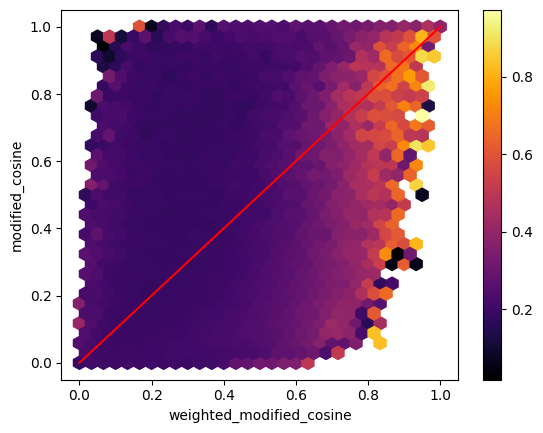

In [10]:
# Look at weighted vs. unweighted scores colored by tanimoto scores
similarities.plot.hexbin('weighted_modified_cosine', 'modified_cosine', C='tanimoto', gridsize=30, cmap='inferno')
plt.plot([0,1], [0,1], c='red')
plt.show()

# Show violin plots

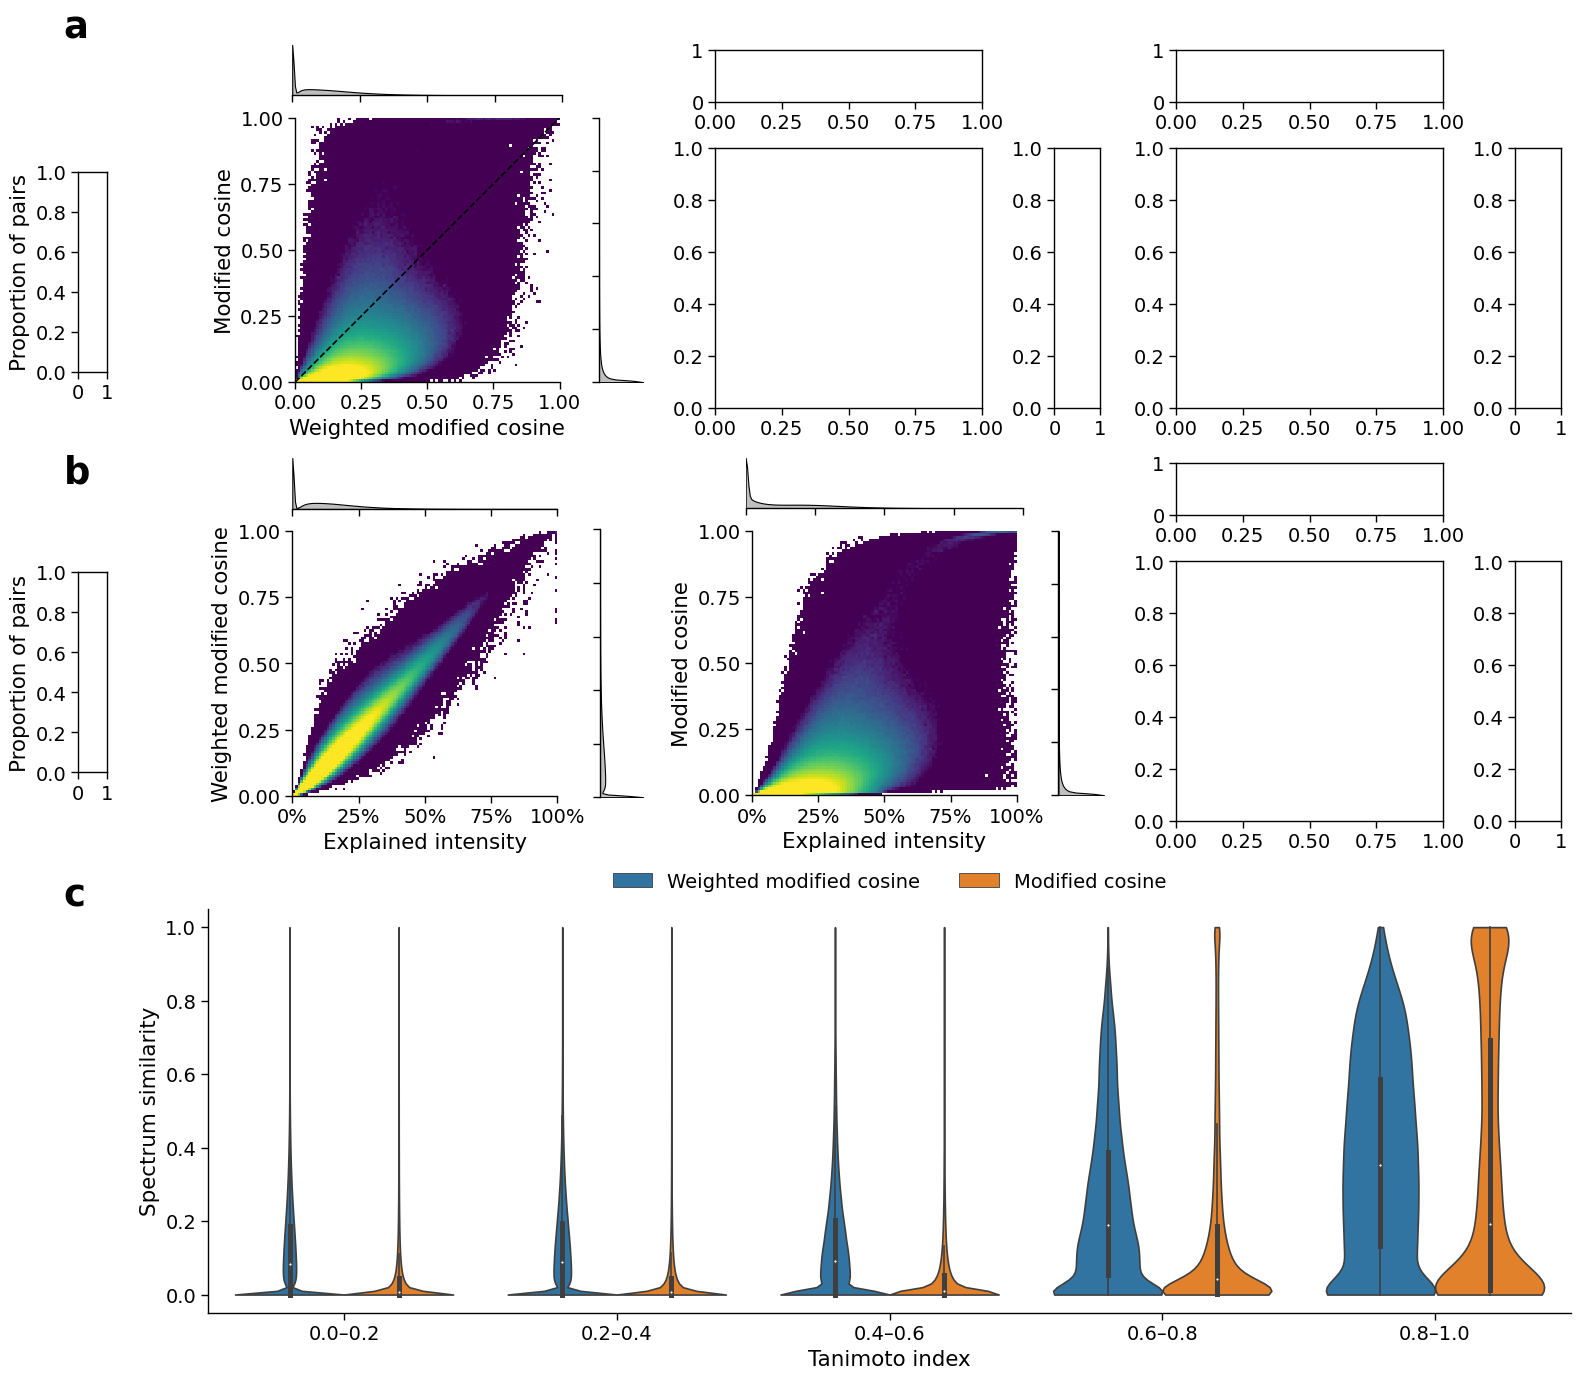

In [15]:
mosaic = """
11111.
222223
222223
222223
222223
222223
"""

bins = 100
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])

with sns.plotting_context("paper", font_scale=1.6):
    fig = plt.figure(constrained_layout=True, figsize=(7.2 * 2, 7.2 / 1.618 * 3))
    gs = GridSpec(3, 3, figure=fig)
    
    # Top panel: Compare different similarities.
    axes_left = fig.add_subfigure(gs[0, 0]).subplot_mosaic(mosaic)
    axes_middle = fig.add_subfigure(gs[0, 1]).subplot_mosaic(mosaic)
    axes_right = fig.add_subfigure(gs[0, 2]).subplot_mosaic(mosaic)
    cbar_ax = fig.add_axes([-0.04, 0.75, 0.02, 0.15])
    
    labels = np.asarray([
        ["weighted_modified_cosine", "modified_cosine"],
    ])

    for i, (axes, (xlabel, ylabel)) in enumerate(
        zip([axes_left, axes_middle, axes_right], labels)
    ):
        # Plot heatmaps.
        hist, _, _ = np.histogram2d(
            similarities[xlabel],
            similarities[ylabel],
            bins=bins,
            range=[[0, 1], [0, 1]],
        )
        hist /= len(similarities)
        heatmap = sns.heatmap(
            np.rot90(hist),
            vmin=0.0,
            vmax=0.001,
            cmap="viridis",
            cbar=i == 2,
            cbar_kws={"format": mticker.StrMethodFormatter("{x:.3%}")},
            cbar_ax=cbar_ax if i == 2 else None,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=axes["2"],
            norm=LogNorm(vmin=0.00001,vmax=0.001),
        )
        axes["2"].yaxis.set_major_locator(tick_locators)
        axes["2"].set_yticklabels(tick_labels[::-1])
        axes["2"].xaxis.set_major_locator(tick_locators)
        axes["2"].set_xticklabels(tick_labels)
        for _, spine in heatmap.spines.items():
            spine.set_visible(True)
        axes["2"].set_xlabel(xlabel.replace("_", " ").capitalize())
        axes["2"].set_ylabel(ylabel.replace("_", " ").capitalize())

        axes["2"].plot(
            [0, bins], [bins, 0], color="black", linestyle="dashed"
        )

        sns.despine(ax=axes["2"])

        # Plot density plots.
        sns.kdeplot(
            data=similarities,
            x=xlabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["1"],
        )
        axes["1"].set_xlim(0, 1)
        axes["1"].xaxis.set_ticklabels([])
        axes["1"].yaxis.set_major_locator(tick_locators)
        axes["1"].set_yticks([])
        sns.despine(ax=axes["1"], left=True)
        sns.kdeplot(
            data=similarities,
            y=ylabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["3"],
        )
        axes["3"].set_ylim(0, 1)
        axes["3"].yaxis.set_ticklabels([])
        axes["3"].xaxis.set_major_locator(tick_locators)
        axes["3"].set_xticks([])
        sns.despine(ax=axes["3"], bottom=True)
        for ax in [axes[c] for c in "13"]:
            ax.set_xlabel("")
            ax.set_ylabel("")
            
    cbar_ax.set_ylabel("Proportion of pairs")
    cbar_ax.yaxis.set_label_position("left")
    # cbar_ax.spines["outline"].set(visible=True, lw=.8, edgecolor="black")
    
    # Middle panel: Compare similarities vs explained intensity.
    axes_left = fig.add_subfigure(gs[1, 0]).subplot_mosaic(mosaic)
    axes_middle = fig.add_subfigure(gs[1, 1]).subplot_mosaic(mosaic)
    axes_right = fig.add_subfigure(gs[1, 2]).subplot_mosaic(mosaic)
    cbar_ax = fig.add_axes([-0.04, 0.45, 0.02, 0.15])
    
    labels = np.asarray([
        ["weighted_modified_cosine_explained", "weighted_modified_cosine"],
        ["modified_cosine_explained", "modified_cosine"],
    ])

    for i, (axes, (xlabel, ylabel)) in enumerate(
        zip([axes_left, axes_middle, axes_right], labels)
    ):
        # Plot heatmaps.
        hist, _, _ = np.histogram2d(
            similarities[xlabel],
            similarities[ylabel],
            bins=bins,
            range=[[0, 1], [0, 1]],
        )
        hist /= len(similarities)
        heatmap = sns.heatmap(
            np.rot90(hist),
            vmin=0.0,
            vmax=0.001,
            cmap="viridis",
            cbar=i == 2,
            cbar_kws={"format": mticker.StrMethodFormatter("{x:.3%}")},
            cbar_ax=cbar_ax if i == 2 else None,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=axes["2"],
            norm=LogNorm(vmin=0.00001,vmax=0.001),
        )
        axes["2"].yaxis.set_major_locator(tick_locators)
        axes["2"].set_yticklabels(tick_labels[::-1])
        axes["2"].xaxis.set_major_locator(tick_locators)
        axes["2"].set_xticklabels(tick_labels)
        axes["2"].xaxis.set_major_formatter(mticker.PercentFormatter())
        for _, spine in heatmap.spines.items():
            spine.set_visible(True)
        axes["2"].set_xlabel("Explained intensity")
        axes["2"].set_ylabel(ylabel.replace("_", " ").capitalize())

        sns.despine(ax=axes["2"])

        # Plot density plots.
        sns.kdeplot(
            data=similarities,
            x=xlabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["1"],
        )
        axes["1"].set_xlim(0, 1)
        axes["1"].xaxis.set_ticklabels([])
        axes["1"].yaxis.set_major_locator(tick_locators)
        axes["1"].set_yticks([])
        sns.despine(ax=axes["1"], left=True)
        sns.kdeplot(
            data=similarities,
            y=ylabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["3"],
        )
        axes["3"].set_ylim(0, 1)
        axes["3"].yaxis.set_ticklabels([])
        axes["3"].xaxis.set_major_locator(tick_locators)
        axes["3"].set_xticks([])
        sns.despine(ax=axes["3"], bottom=True)
        for ax in [axes[c] for c in "13"]:
            ax.set_xlabel("")
            ax.set_ylabel("")
            
    cbar_ax.set_ylabel("Proportion of pairs")
    cbar_ax.yaxis.set_label_position("left")
    # cbar_ax.spines["outline"].set(visible=True, lw=.8, edgecolor="black")
    
    # Bottom panel: Evaluate similarities in terms of the Tanimoto index.
    ax = fig.add_subplot(gs[2, :])
    
    sns.violinplot(
        data=similarities_tanimoto,
        x="tanimoto_interval",
        y="value",
        hue="variable",
        hue_order=["weighted_modified_cosine", "modified_cosine"],
        cut=0,
        scale="width",
        scale_hue=False,
        ax=ax,
    )
    ax.set_xlabel("Tanimoto index")
    ax.set_ylabel("Spectrum similarity")
    for label in ax.legend().get_texts():
        label.set_text(label.get_text().replace("_", " ").capitalize())
    sns.move_legend(
        ax,
        "lower center",
        bbox_to_anchor=(.5, 1),
        ncol=3,
        title=None,
        frameon=False,
    )

    sns.despine(ax=ax)
    
    # Subplot labels.
    for y, label in zip([1, 2/3, 0.35], "abc"):
        fig.text(
            -0.05, y, label, fontdict=dict(fontsize="xx-large", weight="bold")
        )

    # Save figure.
    #plt.savefig("gnps_libraries.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()